회귀 실습 - 자전거 대여 수요 예측
====================================
캐글의 자전거 대여 수요 예측 경연에서 사용된 학습 데이터 이용
- 데이터에 대한 정보
- 2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재되어 있음
- 데이터 세트의 주요 칼럼에 대한 설명
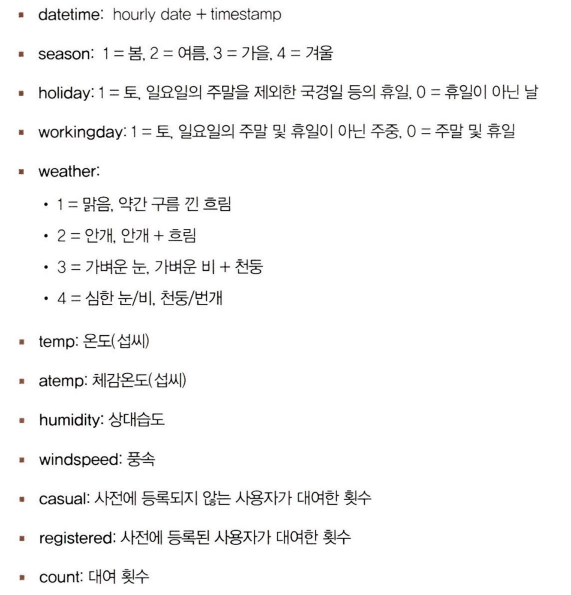

데이터 클렌징 및 가공
-------------------------
학습 데이터 세트를 이용해서 모델 학습 + 대여 횟수(count) 예측하기

In [ ]:
# pg.343 : 데이터 세트를 데이터프레임으로 로드해 대략적인 데이터 확인해보기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike_df=pd.read_csv('/content/sample_data/bike_train.csv')
print(bike_df.shape)
bike_df.head()

10886개의 레코드 , 12개의 칼럼으로 구성되어 있음

In [ ]:
# pg.344 : 데이터 칼럼의 타입 살펴보기

bike_df.info()

- Nul 데이터 x
- 대부분의 칼럼이 int, float 숫자형
- datetime 칼럼 : object형

In [ ]:
# pg.345 : datetime 칼럼 가공하기 (년, 월, 일, 시간의 4개 속성으로 분리)

#문자열을 datetime으로 변경
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)

#datetime 타입에서 년,월,일, 시간 추출
bike_df['year']=bike_df.datetime.apply(lambda x:x.year)
bike_df['month']=bike_df.datetime.apply(lambda x:x.month)
bike_df['day']=bike_df.datetime.apply(lambda x:x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x:x.hour)
bike_df.head(3)

In [ ]:
# casual, registered 칼럼 삭제하기 (casual+registered = count)

drop_columns=['datetime','casual','registered']
bike_df.drop(drop_columns,axis=1,inplace=True)

In [ ]:
# pg.345 : RMSLE, MSE, RMSE 한꺼번에 평가하는 함수 만들기

from sklearn.metrics import mean_squared_error,mean_absolute_error

#log 값 변환 시 NaN등의 이슈로 log()가 아닌 log1p()이용해 RMSLE 계산
def rmsle(y,pred):
  log_y=np.log1p(y)
  log_pred=np.log1p(pred)
  squared_error=(log_y-log_pred)**2
  rmsle=np.sqrt(np.mean(squared_error))
  return rmsle

#사이킷런의 mean_squrae_error() 이용해 RMSE 계싼
def rmse(y,pred):
  return np.sqrt(mean_squared_error(y,pred))

#MSE RMSE,RMLSE 모두 계산
def evaluate_regr(y,pred):
  rmsle_val=rmsle(y,pred)
  rmse_val=rmse(y,pred)
  #MAE는 사이킷런의 mean_absolute_error() 계산
  mae_val=mean_absolute_error(y,pred)
  print('RMSLE: {0:.3f},RMSE:{1:.3f},MAE:{2:.3f}'.format(rmsle_val,rmse_val,mae_val))

In [ ]:
# 다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉬움
def rmsle2(y, pred):
  msle2 = mean_squared_log_error(y, pred)
  rmsle2 = np.sqrt(msle2)
  return rmsle2

log() 보다 log1p() 이용함
- 1 + log() 값으로 log 변환값에 1을 더하므로 문제 해결해줌

로그 변환, 피처 인코딩과 모델 학습/예측/평가
----------------------------------------------

In [ ]:
# pg.347: 사이킷런의 LinearRegression 객체 이용해서 회귀 예측하기

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,LinearRegression

y_target=bike_df['count']
X_features=bike_df.drop(['count'],axis=1,inplace=False)

X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.3,random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

실제 target 데이터 값인 대여 횟수(count)를 감안하면 예측 오류로서 비교적 큰 값임

In [ ]:
# pg.347 : 실제 값과 예측값이 어느 정도 차이나는지 DataFrame 칼럼으로 만들어서 오류값이 가장 큰 순으로 5개 확인하기

def get_top_error_data(y_test,pred,n_tops=5):
  #DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
  result_df=pd.DataFrame(y_test.values,columns=['real_count'])
  result_df['predicted_count']=np.round(pred)
  result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])

  #예측값과 실제값이 가장 큰 데이터 순으로 출력
  print(result_df.sort_values('diff',ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=5)

가장 큰 상위 5위 오류 값은 546-568로 실제 값 감안하면 예측 오류가 꽤 큼

회귀에서 큰 예측 오류 발생할 때
- target 값의 분포가 왜곡된 형태를 이루는지 확인하기
- target 값의 분포는 정규분포 형태가 가장 좋음

In [ ]:
# pg.348 : 자전거 대여 모델의 target값인 count칼럼이 정규분포를 이루는지 확인해보기

y_target.hist()

0~200 사이에 왜곡되어 있음
- 로그 적용해서 변환해주기
- 변경된 target값 기반으로 학습 + 예측값은 다시 expm1()함수 이용해서 원래 scale 값으로 원상복구하기

In [ ]:
# pg.348 : log1p() 적용한 count값의 분포 확인하기

y_log_transform=np.log1p(y_target)
y_log_transform.hist()

target값을 로그 변환한 후
- 정규분포는 아니지만 왜곡 정도가 줄어듦

In [ ]:
# pg.349 : 로그 변환된 target값을 이용해 학습 + 평가 수행하기

#타깃 칼럼인 count값을 log1p로 로그 변환
y_target_log=np.log1p(y_target)

#로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train,X_test,y_train,y_test=train_test_split(X_features,y_target_log,test_size=0.3,random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=lr_reg.predict(X_test)

#테스트 데이터 세트의 Target 값은 로그 변환 됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp=np.expm1(y_test)

#예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp=np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

- RMSLE 오류 : 줄어듦
- RMSE : 늘어남

In [ ]:
# pg.350 : 각 피처의 회귀 계수값 시각화하기

coef=pd.Series(lr_reg.coef_,index=X_features.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values,y=coef_sort.index)

year 피처의 회귀 계수 값이 독보적으로 큰 값을 가짐
- 카테고리형 피처이지만 큰 숫자형으로 되어있음
- 사이킷런은 범주형 변수만을 위한 데이터 타입이 없으므로 숫자로 변환해야 함
- 숫자형 카테고리 값을 선형회귀에 사용할 경우, 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향 받는 경우 발생할 수 있음
- 원핫 인코딩 적용해주기 ! 

In [ ]:
# pg.350 : 범주형 변수 원-핫 인코딩하기

X_features_ohe=pd.get_dummies(X_features,columns=['year','month','day','hour','holiday',
                                                  'workingday','season','weather'])

In [ ]:
# pg.351 : 사이킷런의 선형 회귀 모델인 LinearRegression, Ridge, Lasso 학습해서 예측 성능 확인하기

from sklearn.linear_model import LinearRegression,Ridge,Lasso

# 원핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train,X_test,y_train,y_test=train_test_split(X_features_ohe,y_target_log,test_size=0.3,random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=False):
  model.fit(X_train,y_train)
  pred=model.predict(X_test)
  if is_expm1:
    y_test=np.expm1(y_test)
    pred=np.expm1(pred)
  print('###',model.__class__.__name__,'###')
  evaluate_regr(y_test,pred)

# end of function get_model_predict

# 모델별로 평가 수행
lr_reg=LinearRegression()
ridge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.01)

for model in [lr_reg,ridge_reg,lasso_reg]:
  get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=True)

In [ ]:
# pg.351 : 원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 상위 25개 피처 시각화하기

coef=pd.Series(lr_reg.coef_,index=X_features_ohe.columns)
coef_sort=coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values,y=coef_sort.index)

pg.352~ : 회귀 트리 이용해 회귀 예측 수행하기
- 로그 변환된 target값 + 원-핫 인코딩된 피처 데이터 세트 그대로 이용함
- 랜덤 포레스트, GBM, XGBoost, LightGBM 순차적 성능 평가해봄
- XGBoost의 경우 학습/테스트 데이터를 DataFrame의 values 속성 이용해서 넘파이 ndarray로 변환함

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import  LGBMRegressor

#랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg=RandomForestRegressor(n_estimators=500)
gbm_reg=GradientBoostingRegressor(n_estimators=500)
xgb_reg=XGBRegressor(n_estimators=500)
lgbm_reg=LGBMRegressor(n_estimators=500)

for model in [rf_reg,gbm_reg,xgb_reg,lgbm_reg]:
  #XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능.ndarray로 변환
  get_model_predict(model,X_train.values,X_test.values,y_train.values,y_test.values,is_expm1=True)

앞의 선형 회귀 모델보다 회귀 예측 성능이 개선됨
- 데이터 세트의 유형에 따라 결과는 얼마든지 달라질 수 있음
  - 회귀 트리가 선형 회귀보다 더 나은 성능을 가진다는 의미는 아님

회귀 실습 - 캐글 주택 가격: 고급 회귀 기법
================================================
캐글의 캐글 주택 가격: 고급 회귀 기법 데이터 세트 이용
- 79개의 변수
- 학습 데이터명 : house_price
- 성능 평가는 RMSLE를 기반으로 함
  - 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로 이를 상쇄하기 위해 오류 값을 로그변환한 RMSLE 이용

데이터 사전 처리(Preprocessing)
----------------------------------

In [ ]:
# pg.354 : 필요한 모듈, 데이터 로딩 + 개략적인 데이터 확인

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org=pd.read_csv('/content/sample_data/house_price.csv')
house_df=house_df_org.copy()
house_df.head(3)

target 값 : SalePrice

In [ ]:
# pg.355 : 데이터 세트의 전체 크기, 칼럼의 타입, Null이 있는 칼럼과 건수 내림차순으로 출력하기

print('데이터 세트의 Shape:',house_df.shape)
print('\n 전체 피처의 type:\n',house_df.dtypes.value_counts())
isnull_series=house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n',isnull_series[isnull_series>0].sort_values(ascending=False))

- 1460개의 레코드와 81개의 피처로 구성
- 피처의 타입 : 문자형 / 숫자형
- 데이터 양에 비해 Null값이 많은 피처도 있음 -> 드롭해주기

In [ ]:
# pg.356 : 타깃 값의 분포도 확인하기

plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

In [ ]:
# pg.356 : 결괏값을 로그 변환해서 정규분포 형태로 변환해주기 + 분포도 다시 확인하기

plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

타깃값인 SalePrice을 로그 변환해서 정규분포 형태로 결괏값이 분포됨

In [ ]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

# 드롭하지 않은 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type :\n',house_df.dtypes[null_column_count.index])

In [ ]:
# pg.358 : 문자형 피처를 모두 원-핫 인코딩해주기 + 원-핫 인코딩 이후 칼럼이 얼마나 늘어났는지 확인하기

print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

원-핫 인코딩 이후 피처가 75개 -> 272개로 증가함

선형 회귀 모델 학습/예측/평가
--------------------------------
타깃값, 예측값, 실제값 : 모두 로그 변환됨
- 예측 결과 오류에 RMSE 적용하면 RMSLE가 자동으로 측정됨

In [ ]:
# pg.359 : 로그 변환된 RMSE를 계산하는 함수 생성하기

# 단일 모델의 RMSE값을 반환함
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, ' 로그 변환된 RMSE:',np.round(rmse, 3))

# get_rmse()함수 이용해서 여러 모델의 RMSE값을 반환함
def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [ ]:
# pg.359 : 여러 선형 회귀 모델 학습+예측+평가하기

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

라쏘 회귀 : 타 회귀 방식보다 회귀 성능이 많이 떨어짐
-> 최적 하이퍼 파라미터 튜닝해주기

In [ ]:
# pg.360 : 피처별 회귀 계수 시각화하기

def get_top_bottom_coef(model, n=10):
  # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명
  coef = pd.Series(model.coef_, index=X_features.columns)

  # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

In [ ]:
# list객체로 모델 입력받아서 모델별로 회귀 계수 상하위 10개 추출해서 가로 막대 그래프 출력하는 함수

def visualize_coefficient(models):
  # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
  fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
  fig.tight_layout()
  # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
  for i_num, model in enumerate(models):
    # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])
    # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
    axs[i_num].set_title(model.__class__.__name__+' Coefficents', size=25)
    axs[i_num].tick_params(axis="y", direction="in", pad=-120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- OLS 기반의 LinearRegression, Ridge : 회귀 계수가 유사한 형태로 분포되어 있음
- 라쏘 : 전체적으로 회귀 계수값이 매우 작음

In [ ]:
# pg.362: 전체 데이터 세트를 5개의 교차 검증 폴드 세트로 분할해 평균 RMSE 측정하기

from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

  for model in models:
    # 분할하지 않고 전체데이터로 cross_val_score() 수행. 모델별 CV RMSE값과 평균 RMSE 출력
    rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring="neg_mean_squared_error", cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
    print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

여전히 라쏘가 다른 모델들보다 성능이 떨어짐
- 학습/테스트 데이터 세트 분할 과정에 문제가 발생한 것은 아님을 알 수 있음

In [ ]:
# pg.363 : 릿지, 라쏘 모델에 대해 alpha 하이퍼 파라미터 변화시키면서 최적값 도출해보기

from sklearn.model_selection import  GridSearchCV

# 모델과 하이퍼 파라미터 딕셔너리 객체를 받아 최적화 작업의 결과를 표시하는 함수
def print_best_params(model,params):
  grid_model=GridSearchCV(model,param_grid=params, scoring='neg_mean_squared_error',cv=5)
  grid_model.fit(X_features,y_target)
  rmse=np.sqrt(-1*grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                           np.round(rmse,4),grid_model.best_params_))

ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

라쏘 모델 : alpha값 최적화 이후 예측 성능이 많이 좋아짐

In [ ]:
# pg.363 : 선형 모델에 최적 alpha값 설정 + 학습/예측/평가 수행 + 모델별 회귀계수 시각화하기

# 앞의 최적화 알파 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- alpha값 최적화 후 테스트 데이터 세트의 예측 성능이 더 좋아짐
- 릿지, 라쏘 모델에서 비슷한 피처의 회귀 계수가 높음

pg.365~ : 데이터 세트 추가 가공해서 모델 튜닝 더 해보기
1. 피처 데이터 세트의 데이터 분포도
2. 이상치(outlier) 데이터 처리



-
1. 피처 데이터 세트의 데이터 분포도

  사이파이 stats모듈의 skew()함수 : 칼럼의 데이터 세트의 왜곡된 정도 추출 가능
  - skew() 함수의 반환 값 >= 1 : 왜곡 정도가 높음
  - 1 이상의 값을 반환하는 피처만 추출 + 왜곡 정도를 완화하기 위해 로그 변환 적용함

- 숫자형 피처의 칼럼 index객체 추출해 구한 숫자형 칼럼 데이터 세트의 apply lambda식 skew() 호출해서 숫자형 피처의 왜곡 정도 구함
- skew() 적용하는 숫자형 피처에서 원-핫 인코딩된 카데고리 숫자형 피처는 제외하기
  - 카테고리 피처 : 코드성 피처 -> 인코딩 시 왜곡 가능성 높음
  - skew() 함수 적용하는 DataFrame : 원-핫 인코딩이 적용되지 않은 house_df

In [ ]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index=house_df.dtypes[house_df.dtypes!='object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features=house_df[features_index].apply(lambda x:skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출
skew_features_top=skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

In [ ]:
# pg.366 : 추출된 왜곡 정도가 높은 피처를 로그 변환하기

house_df[skew_features_top.index]=np.log1p(house_df[skew_features_top.index])

여전히 높은 왜곡 정도를 가진 피처가 존재함
- but. 더이상 로그 변환해도 개선하긴 어려우므로 그대로 유지하기

In [ ]:
# 왜곡 정도 높은 피처 로그 변환 했으므로 다시 원-핫 인코딩 적용하여 피처/타깃 데이터 세트 생성
house_df_ohe=pd.get_dummies(house_df)
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.2,random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

릿지 모델
- 최적 alpha값 : 12 -> 10
- 5폴드 교차 검증의 평균 RMSE값 : 0.1418 -> 0.1275 (향상)

라쏘 모델
- 5폴드 교차 검증의 평균 RMSE값 : 0.142 -> 0.1252 (향상)

In [ ]:
# 모델별 회귀 계수 시각화하기

# 앞의 최적화 알파 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 세 모델 모두 GrLivArea, 즉 주거 공간 크기가 회귀 계수가 가장 높은 피처
- 주거 공간의 크기가 주택 가격에 미치는 영향이 가장 높음을 알려줌

2. 이상치 데이터
- 회귀계수가 높은(=예측에 많은 영향 미치는) 피처의 이상치 데이터 처리는 중요 !

In [ ]:
# pg.367 : 원본 데이터 세트인 house_df_org에서 GrLivArea와 타깃값 SalePrice간의 관계 시각화하기

plt.scatter(x=house_df_org['GrLivArea'],y=house_df_org['SalePrice'])
plt.ylabel('SalePrice',fontsize=15)
plt.xlabel('GrLivArea',fontsize=15)
plt.show()

GrLivArea피처, SalePrice : 양의 상관관계가 매우 높음
- 두 개의 outlier 존재 -> 삭제하기

In [ ]:
# pg.368 : 데이터 변환이 모두 완료된 house_df_ohe에서 대상 데이터 필터링하기

# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성 + 불린 인덱싱으로 대상 찾기
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index : ', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape : ', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape : ', house_df_ohe.shape)

두 개의 데이터를 삭제해서 레코드는 1460 -> 1458개로 줄어듦

In [ ]:
# pg.368 : 업데이트된 house_df_ohe 기반으로 피처, 타깃 데이터 세트 다시 생성 + 릿지,라쏘 모델의 최적화 수행하기

# 업데이트된 house_df_ohe 기반으로 피처, 타깃 데이터 세트 다시 생성
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1,inplace=False)

# print_best_params()이용해서 릿지, 라쏘 모델의 최적화 수행
X_train,X_test,y_train,y_test = train_test_split(X_features,y_target,test_size=0.2,random_state=156)

ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

예측 수치가 매우 크게 향상됨

릿지 모델
- 최적 alpha값 : 12 -> 8
- 평균 RMSE : 0.1275 -> 0.1125 (개선됨)

라쏘 모델
- 평균 RMSE : 0.128 -> 0.114 (매우 낮아짐 -> GOOD)


바람직한 머신러닝 모델 생성 과정
1. 대략의 데이터 가공과 모델 최적화 수행하기
2. 이에 기반한 여러 가지 기법의 데이터 가공 + 하이퍼 파라미터 기반의 모델 최적화 반복 수행하기

In [ ]:
# pg.369 : 이상치 제거된 데이터 세트 기반으로 다시 분할된 데이터 세트의 RMSE 수치, 회귀 계수 시각화하기

# 모델별 회귀 계수 시각화하기

# 앞의 최적화 알파 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

회귀 트리 모델 학습/예측/평가
----------------------------------
수행시간 절약 위해 미리 하이퍼 파라미터 설정함

In [ ]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000,learning_rate=0.05,colsample_bytree=0.5,subsample=0.8)
print_best_params(xgb_reg,xgb_params)

XGBoost 회귀 트리 적용했을 때 5폴드 세트 평균 RMSE : 0.1182

In [ ]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000,learning_rate=0.05,num_leaves=4,subsample=0.6,colsample_bytree=0.4,reg_labmda=10,n_jobs=-1)
print_best_params(lgbm_reg,lgbm_params)

LightGBM 적용 시 5폴드 세트 평균 RMSE : 0.1162

회귀 모델의 예측 결과 혼합을 통한 최종 예측
---------------------------------------------
개별 회귀 모델의 예측 결괏값을 혼합해 이를 기반으로 최종 회귀 값 예측하기

예측 결과 혼합의 방법
- A모델 예측값의 0.4 + B모델 예측값의 0.6 -> 최종 회귀 값으로 예측하기

예)

  A 회귀모델 예측값 : [100,80,60]

  B 회귀모델 예측값 : [120,80,50]

  최종 회귀 예측값 : [100 *0.4 + 120 *0.6, 80 *0.4 + 80 *0.6, 60 *0.4 + 50 *0.6] = [112,80,54]


In [ ]:
# pg.371

# 최종 혼합 모델, 개별 모델의 RMSE값 출력 함수
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test,pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE:{1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds={'최종 혼합':pred,
       'Ridge':ridge_pred,
       'Lasso':lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE가 개별 모델보다 성능 면에서 약간 개선됨
- 0.4, 0.6을 정하는 특별한 기준은 없음
- 두 개 중에 성능 좋은 쪽에 가중치 더 주기

In [ ]:
# pg.372 : XGBoost, LightGBM 혼합하기

# 개별 모델 학습
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

# 개별 모델 예측
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종혼합':pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력        
get_rmse_pred(preds)

혼합 모델의 RMSE가 개별 모델의 RMSE보다 조금 향상됨

스태킹 앙상블 모델을 통한 회귀 예측
-------------------------------------
스태킹 모델
- 두 종류 모델 필요
1. 개별적인 기반 모델
2. 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델

스태킹 모델의 핵심
- 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 최종 메타 모델이 학습할 피처 데이터 세트 : 원본 학습피처 세트로 학습한 개별모델의 예측값을 스태킹 형태로 결합한 것
# 개별 기반 모델에서 최종 메타모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # 지정된 nfolds값으로 kfold 생성
  kf = KFold(n_splits = n_folds, shuffle=True, random_state=0)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')
  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
    model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:, folder_counter] = model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

In [ ]:
# pg.374 : get_stacking_base_datasets() 모델별로 적용해서 메타 모델이 사용할 데이터 세트 추출하기

# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train,lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

In [ ]:
# pg.375 : 개별 모델이 반환하는 학습용 피처 데이터, 테스트용 피처 데이터 세트 결합해서 최종 메타 모델에 적용하기

# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:',rmse)

스태킹 회귀 모델 적용한 결과
- 테스트 데이터 세트에서 RMSE가 0.0984로 현재까지 가장 좋은 성능 평가를 보여줌